In [23]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from nltk.corpus import stopwords
import spacy
import nltk
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff

In [18]:
stop_words = set(stopwords.words('english'))
nlp=spacy.load('en_core_web_sm')

In [11]:
# Reading a CSV file containing sentiment data, skipping bad lines
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding="latin", header=None, on_bad_lines='skip')

# Renaming columns for better clarity
df.rename(columns={0: 'labels', 5: 'tweets'}, inplace=True)

# Dropping unnecessary columns from the DataFrame
df.drop([1, 2, 3, 4], axis=1, inplace=True)

# Replacing label 4 (positive sentiment) with 1 for uniformity
df['labels'] = df['labels'].replace(4, 1)

# Randomly shuffling the DataFrame and selecting a subset of 10,000 rows
df = df.sample(frac=1)
df = df.head(10000)

# Displaying the first few rows of the DataFrame
df.head()


,labels,tweets
490003,0,Locked myself out of house and car today.
1140022,1,"@cupcakeloser Yeah, it's cool, means I can go ..."
1589790,1,Packing to go to Sweden!!
1385134,1,@D2LC_Lexy lexyy! see ya at the meeting
898611,1,woot just ordered some awesome hair goodies fr...


In [19]:
# Function to get the number of words in a tweet
def get_word_len(tweet):
    return len(tweet.split(' '))

# Function to get the number of characters in a tweet
def get_char_len(tweet):
    return len(tweet)

# Function to preprocess a tweet
def preprocess_tweet(tweet):
    # Convert the tweet to lowercase
    tweet = tweet.lower()
    
    # Remove URLs from the tweet
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove mentions (e.g., @username) from the tweet
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Remove special characters and punctuation from the tweet
    tweet = re.sub(r'[^\w\s#]', '', tweet)
    
    # Lemmatize the words using spaCy
    tokens = [token.lemma_ for token in nlp(tweet)]
    
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Remove single-character tokens
    tokens = [token for token in tokens if len(token) > 1]
    
    # Join the processed tokens to form the cleaned tweet
    processed_tweet = ' '.join(tokens)
    
    return processed_tweet

# Apply the preprocess_tweet function to each tweet in the dataframe
df['clean_tweets'] = [preprocess_tweet(tw) for tw in tqdm(df['tweets'], position=0, leave=True)]

# Calculate the number of words in each cleaned tweet and store it in a new column
df['tweet_words_length'] = df['clean_tweets'].apply(get_word_len)

# Calculate the number of characters in each cleaned tweet and store it in a new column
df['tweet_chars_length'] = df['clean_tweets'].apply(get_char_len)

# Display the first few rows of the dataframe
df.head()


100%|██████████| 10000/10000 [01:36<00:00, 103.72it/s]


,labels,tweets,clean_tweets,tweet_words_length,tweet_chars_length
490003,0,Locked myself out of house and car today.,lock house car today,4,20
1140022,1,"@cupcakeloser Yeah, it's cool, means I can go ...",yeah cool mean go visit catchup coffee ink,8,42
1589790,1,Packing to go to Sweden!!,pack go sweden,3,14
1385134,1,@D2LC_Lexy lexyy! see ya at the meeting,lexyy see ya meeting,4,20
898611,1,woot just ordered some awesome hair goodies fr...,woot order awesome hair goody etsy,6,34


In [24]:
# Count the number of positive and negative tweets in the dataframe
positive_count = df[df['labels'] == 1].shape[0]
negative_count = df[df['labels'] == 0].shape[0]

# Create a pie chart using Plotly Express to visualize the distribution of positive and negative tweets
fig = px.pie(
    values=[positive_count, negative_count],  # Values represent the counts of positive and negative tweets
    title='Distribution of Positive and Negative Tweets',  # Title of the pie chart
    names=['Positive', 'Negative'],  # Labels for the two categories
    hover_name=['Positive', 'Negative'],  # Hover information for each category
    opacity=.9,  # Opacity of the pie chart
    template='simple_white'  # Plotly template for the chart
)

# Display the pie chart
fig.show()


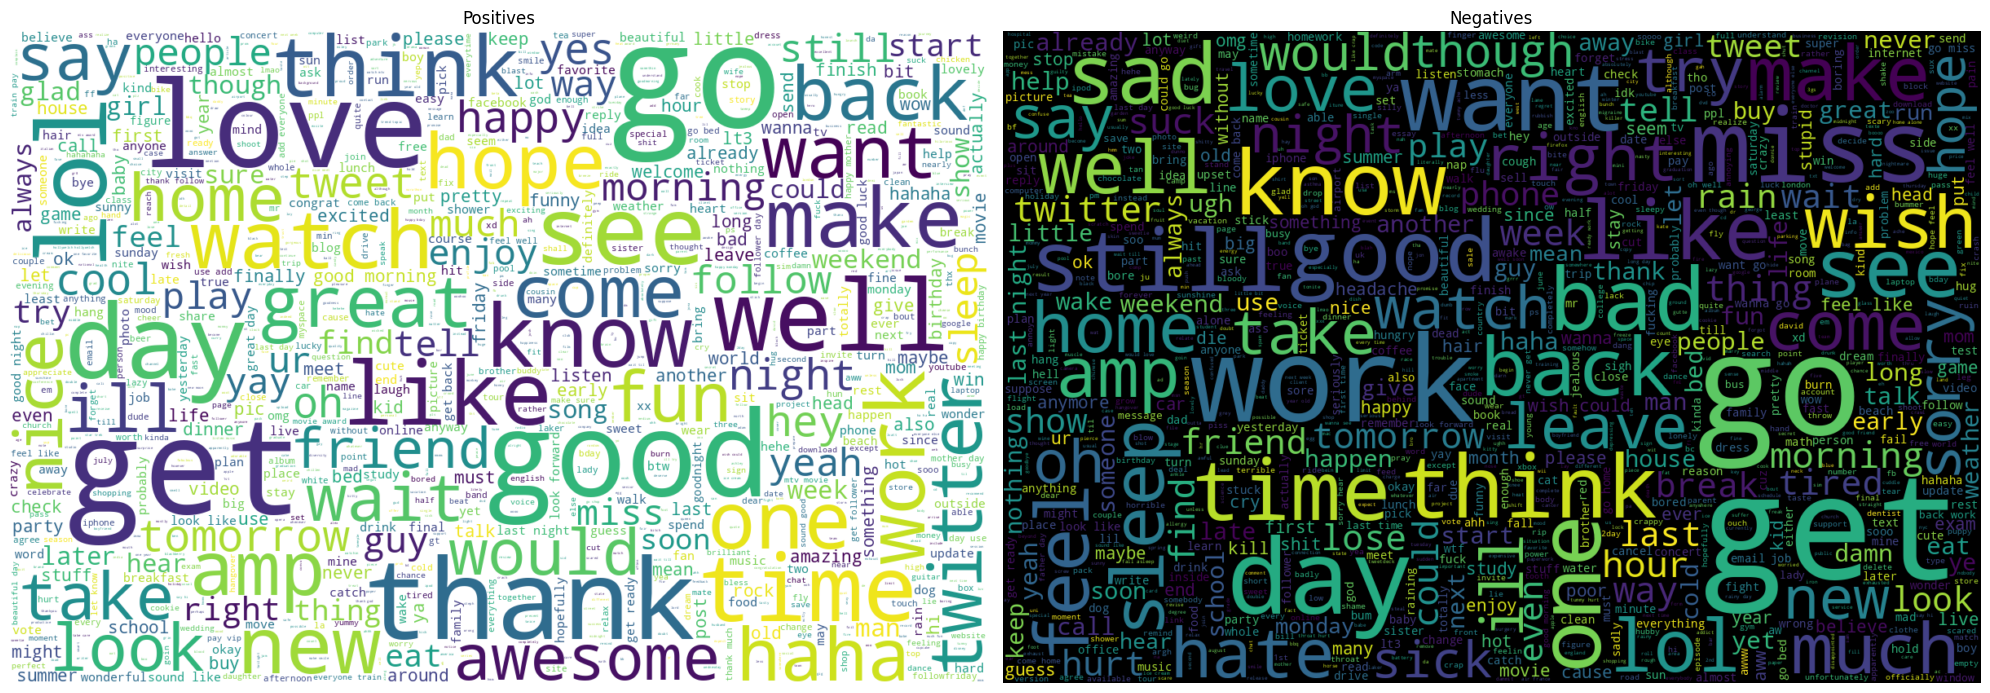

In [26]:
from wordcloud import WordCloud
# Set up a figure with a specified size
plt.figure(figsize=(20, 8))

# Define stopwords for WordCloud (common words to exclude)
STOPWORDS = ['im','today','really','need','tonight']

# Plot two subplots side by side
plt.subplot(1, 2, 1)

# Generate and display a WordCloud for positive tweets
wordcloud_1 = WordCloud(
    width=1200, height=800, max_words=1000, contour_width=2,
    background_color='white', stopwords=STOPWORDS, max_font_size=180,
    colormap='viridis'
).generate(' '.join(df[df['labels'] == 1]['clean_tweets']))

plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.title('Positives')

# Plot the second subplot
plt.subplot(1, 2, 2)

# Generate and display a WordCloud for negative tweets
wordcloud_2 = WordCloud(
    width=1200, height=800, max_words=1000, contour_width=2,
    background_color='black', stopwords=STOPWORDS, max_font_size=180,
    colormap='viridis'
).generate(' '.join(df[df['labels'] == 0]['clean_tweets']))

plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis('off')
plt.title('Negatives')

# Turn off axis for the entire plot
plt.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


In [27]:
# Create distribution plots for word count and character count for positive and negative tweets
fig_words = ff.create_distplot(
    [df[df['labels'] == 1]['tweet_words_length'], df[df['labels'] == 0]['tweet_words_length']],
    ['Positive', 'Negative'],
    bin_size=25,
    show_hist=False,
    show_rug=False
)

fig_chars = ff.create_distplot(
    [df[df['labels'] == 1]['tweet_chars_length'], df[df['labels'] == 0]['tweet_chars_length']],
    ['Positive', 'Negative'],
    bin_size=25,
    show_hist=False,
    show_rug=False
)

# Set titles and labels for the distribution plots
fig_chars.update_layout(title="Distribution Plot on Character Count", xaxis_title="Number of Characters", yaxis_title="Frequency")
fig_words.update_layout(title="Distribution Plot on Word Count", xaxis_title="Number of Words", yaxis_title="Frequency")

# Combine the plots in a 2-column layout
fig = make_subplots(rows=1, cols=2, subplot_titles=["Word Count", "Character Count"])
fig.add_trace(fig_words['data'][0], row=1, col=1)
fig.add_trace(fig_words['data'][1], row=1, col=1)
fig.add_trace(fig_chars['data'][0], row=1, col=2)
fig.add_trace(fig_chars['data'][1], row=1, col=2)

# Update overall layout and show the plot
fig.update_layout(title_text="Distribution Plots - Word Count vs Character Count", showlegend=True, font=dict(family="Arial", size=15, color="black"))
fig.show()


In [29]:
from sklearn.model_selection import train_test_split
# Splitting the dataset into training and testing sets with an 80-20 split
x_train, x_test, y_train, y_test = train_test_split(df['clean_tweets'], df['labels'], test_size=0.2, random_state=42)

# Further splitting the test set into validation and final test sets with a 50-50 split
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

# Creating a pie chart to visualize the distribution of tweet counts in training, testing, and validation sets
fig = px.pie(values=[len(x_train), len(x_test), len(x_val)], title='Distribution of Training, Testing, and Validation Tweets', 
             names=['Training', 'Testing', 'Validation'], hover_name=['Training', 'Testing', 'Validation'], opacity=0.9, template='simple_white')

# Displaying the pie chart
fig.show()


### Neural Network with One Hot Encoding

In [32]:
# Configuration for training a neural network: 10 epochs, input sequence length of 20, 
# batch size of 64, 80% training data, and 100-dimensional word embeddings.
epochs_ = 10
seq_len = 20
batch_size_ = 64
training_size = 0.8
embedding_len = 100


In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# Using CountVectorizer with binary encoding for tweets
vec = CountVectorizer(binary=True)
vec = vec.fit(df['clean_tweets'])

# Transforming and converting tweets into arrays
enc_tweets = vec.transform(df['clean_tweets']).toarray()

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['labels'], test_size=training_size, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

# Building a neural network model with multiple dense layers and dropout for regularization
model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=(enc_tweets.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model using binary crossentropy loss and Adam optimizer with a specified learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Training the model and storing the training history
history_1 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Evaluating and printing the model's accuracy on the testing data
print('\n')
print("Model Evaluation on Testing Data: ", round(model.evaluate(x_test, y_test)[1] * 100, 2))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 444ms/step - accuracy: 0.4940 - loss: 0.6929 - val_accuracy: 0.5365 - val_loss: 0.6925
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 422ms/step - accuracy: 0.5190 - loss: 0.6914 - val_accuracy: 0.5870 - val_loss: 0.6909
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 433ms/step - accuracy: 0.5628 - loss: 0.6878 - val_accuracy: 0.5702 - val_loss: 0.6880
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 416ms/step - accuracy: 0.6185 - loss: 0.6740 - val_accuracy: 0.6058 - val_loss: 0.6794
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 433ms/step - accuracy: 0.6645 - loss: 0.6528 - val_accuracy: 0.5855 - val_loss: 0.6673
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.7205 - loss: 0.5963 - val_accuracy: 0.6513 - val_loss: 0.6401
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 431ms/step - accuracy: 0.8580 - loss: 0.4945 - val_accuracy: 0.6790 - val_loss: 0.6111
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.9155 - loss: 0.3563 - val_accu

### Neural Network with CountVectorizer

In [35]:
# Using CountVectorizer without binary encoding for tweets
vec = CountVectorizer(binary=False)
vec = vec.fit(df['clean_tweets'])

# Transforming and converting tweets into arrays
enc_tweets = vec.transform(df['clean_tweets']).toarray()

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['labels'], test_size=training_size, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

# Building a neural network model with multiple dense layers and dropout for regularization
model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=(enc_tweets.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model using binary crossentropy loss and Adam optimizer with a specified learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Training the model and storing the training history
history_2 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Evaluating and printing the model's accuracy on the testing data
print('\n')
print("Model Evaluation on Testing Data: ", round(model.evaluate(x_test, y_test)[1] * 100, 2))


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 442ms/step - accuracy: 0.4974 - loss: 0.6928 - val_accuracy: 0.5512 - val_loss: 0.6920
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step - accuracy: 0.5180 - loss: 0.6908 - val_accuracy: 0.5788 - val_loss: 0.6894
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 436ms/step - accuracy: 0.6234 - loss: 0.6810 - val_accuracy: 0.6205 - val_loss: 0.6837
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.6176 - loss: 0.6696 - val_accuracy: 0.6480 - val_loss: 0.6693
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 447ms/step - accuracy: 0.7205 - loss: 0.6335 - val_accuracy: 0.6610 - val_loss: 0.6416
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 422ms/step - accuracy: 0.8071 - loss: 0.5477 - val_accuracy: 0.6745 - val_loss: 0.6077
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 433ms/step - accuracy: 0.8814 - loss: 0.4159 - val_accuracy: 0.6765 - val_loss: 0.5997
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 423ms/step - accuracy: 0.9421 - loss: 0.2654 - val_accu

### Neural Network with TFIDF

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Using CountVectorizer without binary encoding for tweets
vec = CountVectorizer(binary=False)
vec = vec.fit(df['clean_tweets'])

# Transforming and converting tweets into arrays
enc_tweets = vec.transform(df['clean_tweets']).toarray()

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['labels'], test_size=training_size, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

# Building a neural network model with multiple dense layers and dropout for regularization
model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=(enc_tweets.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model using binary crossentropy loss and Adam optimizer with a specified learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Training the model and storing the training history
history_2 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Evaluating and printing the model's accuracy on the testing data
print('\n')
print("Model Evaluation on Testing Data: ", round(model.evaluate(x_test, y_test)[1] * 100, 2))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5140 - loss: 0.6925 - val_accuracy: 0.5472 - val_loss: 0.6922
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 467ms/step - accuracy: 0.6124 - loss: 0.6715 - val_accuracy: 0.6690 - val_loss: 0.6736
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 449ms/step - accuracy: 0.7433 - loss: 0.6366 - val_accuracy: 0.6647 - val_loss: 0.6490
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 442ms/step - accuracy: 0.8132 - loss: 0.5629 - val_accuracy: 0.6795 - val_loss: 0.6137
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 436ms/step - accuracy: 0.8841 - loss: 0.4259 - val_accuracy: 0.6825 - val_loss: 0.5990
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 452ms/step - accuracy: 0.9274 - loss: 0.2996 - val_accuracy: 0.6840 - val_loss: 0.6301
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - accuracy: 0.9651 - loss: 0.1833 - val_accuracy: 0.6755 - val_loss: 0.7109
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 450ms/step - accuracy: 0.9794 - loss: 0.1111 - val_accura

### Neural Network with Text Sequences

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Initializing a Tokenizer and fitting it on the preprocessed cleaned tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_tweets'])

# Creating word index and index word mappings for reference
word_index = tokenizer.word_index
index_word = tokenizer.index_word

# Converting the cleaned tweets to sequences of integers using the Tokenizer
sequences = tokenizer.texts_to_sequences(df['clean_tweets'])
enc_tweets = pad_sequences(sequences, maxlen=seq_len, padding='post')

# Splitting the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['labels'], test_size=training_size, random_state=42)

# Further splitting the testing set into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)


In [43]:
# Creating a sequential model with dense layers for a binary classification task
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(seq_len,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model with binary crossentropy loss, Adam optimizer, and accuracy metric
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Training the model on the training data and validating on the validation data
history_4 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Evaluating and printing the accuracy on the testing data
print('\n')
print("Model Evaluation on Testing Data:", round(model.evaluate(x_test, y_test)[1] * 100, 2))


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5039 - loss: 238.7704 - val_accuracy: 0.4910 - val_loss: 193.2889
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4891 - loss: 170.6929 - val_accuracy: 0.4985 - val_loss: 140.3303
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4874 - loss: 129.3546 - val_accuracy: 0.5063 - val_loss: 110.4148
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4899 - loss: 98.3740 - val_accuracy: 0.5027 - val_loss: 90.0503
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4988 - loss: 87.2042 - val_accuracy: 0.5063 - val_loss: 75.3399
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4977 - loss: 72.5267 - val_accuracy: 0.5080 - val_loss: 64.5175
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5225 - loss: 54.0308 - val_accuracy: 0.5107 - val_loss: 57.6497
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4905 - loss: 59.7264 - val_accuracy: 0.5020 

### Neural Network with Word Embeddings

In [46]:
from tensorflow.keras.layers import Embedding,Dense, Dropout,Flatten
# Create a sequential model
model = Sequential()

# Add an embedding layer with specified input dimensions, output dimensions, and input length
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_len, input_length=seq_len))

# Flatten the 3D output to 2D for further processing
model.add(Flatten())

# Add a densely connected layer with 64 neurons and ReLU activation function
model.add(Dense(64, activation='relu'))

# Add another densely connected layer with 32 neurons and ReLU activation function
model.add(Dense(32, activation='relu'))

# Add a final densely connected layer with 1 neuron and sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss, Adam optimizer, and accuracy as the metric
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the model on training data, validate on validation data, and store training history
history_5 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))
print('\n')
# Evaluate the model on testing data and print the accuracy
print("Model Evaluation on Testing Data: ", round(model.evaluate(x_test, y_test)[1] * 100, 2))


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4751 - loss: 0.6935 - val_accuracy: 0.5095 - val_loss: 0.6929
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5869 - loss: 0.6913 - val_accuracy: 0.5157 - val_loss: 0.6926
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6356 - loss: 0.6891 - val_accuracy: 0.5425 - val_loss: 0.6922
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6880 - loss: 0.6846 - val_accuracy: 0.5437 - val_loss: 0.6915
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7516 - loss: 0.6787 - val_accuracy: 0.5543 - val_loss: 0.6902
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8196 - loss: 0.6697 - val_accuracy: 0.5770 - val_loss: 0.6875
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8455 - loss: 0.6549 - val_accuracy: 0.5520 - val_loss: 0.6840
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8224 - loss: 0.6291 - val_accuracy: 0.5938 - v

### LSTM Model

In [47]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Create a Sequential model
model = Sequential()

# Add an Embedding layer with input dimensions, output dimensions, and input length
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_len, input_length=seq_len))

# Add an LSTM layer with 128 units, dropout of 0.2, and return sequences for the next layer
model.add(LSTM(units=128, dropout=0.2, return_sequences=True))

# Add another LSTM layer with 64 units
model.add(LSTM(64))

# Add a Dense layer with 64 units and ReLU activation function
model.add(Dense(64, activation='relu'))

# Add a Dropout layer with dropout rate of 0.5
model.add(Dropout(0.5))

# Add a Dense layer with 1 unit and sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss, Adam optimizer with learning rate of 0.0001, and accuracy metric
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the model on training data and validate on validation data
history_6 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Print a newline for better readability
print('\n')

# Evaluate and print the model accuracy on testing data
print("Model Evaluation on Testing Data:", round(model.evaluate(x_test, y_test)[1] * 100, 2))

# Save the model to a file
model.save('Embedding_LSTM.h5')


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.4967 - loss: 0.6931 - val_accuracy: 0.5195 - val_loss: 0.6929
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.5242 - loss: 0.6927 - val_accuracy: 0.5195 - val_loss: 0.6928
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.5027 - loss: 0.6930 - val_accuracy: 0.5195 - val_loss: 0.6927
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.5251 - loss: 0.6926 - val_accuracy: 0.5195 - val_loss: 0.6926
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.5058 - loss: 0.6927 - val_accuracy: 0.5197 - val_loss: 0.6923
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.5110 - loss: 0.6922 - val_accuracy: 0.5217 - val_loss: 0.6912
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.5894 - loss: 0.6878 - val_accuracy: 0.6453 - val_loss: 0.6808
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.7418 - loss: 0.6366 - val_accuracy: 0.6465 - 

### GRU Model

In [48]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
# Define a Sequential model
model = Sequential()
# Add an Embedding layer to the model
# input_dim: Vocabulary size (length of word_index + 1)
# output_dim: Dimension of the dense embedding
# input_length: Length of input sequences
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_len, input_length=seq_len))
# Add a GRU layer with 128 units and dropout for sequence data
model.add(GRU(128, dropout=0.2, return_sequences=True))
# Add another GRU layer with 64 units
model.add(GRU(64))
# Add a Dense layer with 64 units and ReLU activation function
model.add(Dense(64, activation='relu'))
# Add a Dropout layer with a dropout rate of 0.5
model.add(Dropout(0.5))
# Add the output layer with 1 unit and a sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))
# Compile the model with binary crossentropy loss, Adam optimizer, and accuracy metric
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
# Train the model on training data, validate on validation data
history_7 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))
# Evaluate and print the accuracy on testing data
print('\n')
print("Model Evaluation on Testing Data : ", round(model.evaluate(x_test, y_test)[1] * 100, 2))


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.4870 - loss: 0.6935 - val_accuracy: 0.5190 - val_loss: 0.6930
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.4904 - loss: 0.6933 - val_accuracy: 0.4823 - val_loss: 0.6932
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.5225 - loss: 0.6929 - val_accuracy: 0.5192 - val_loss: 0.6929
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.5151 - loss: 0.6927 - val_accuracy: 0.5192 - val_loss: 0.6930
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.5192 - loss: 0.6928 - val_accuracy: 0.5192 - val_loss: 0.6929
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.4995 - loss: 0.6934 - val_accuracy: 0.5192 - val_loss: 0.6928
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.5012 - loss: 0.6934 - val_accuracy: 0.5192 - val_loss: 0.6928
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.4944 - loss: 0.6936 - val_accuracy: 0.5192 

### Bidirectional + GRU + Embedding with Text Sequencess:

In [50]:
from tensorflow.keras.layers import Bidirectional
# Create a Sequential model
model = Sequential()

# Add an embedding layer with vocabulary size, embedding dimension, and sequence length
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_len, input_length=seq_len))

# Add a bidirectional GRU layer with 128 units and return sequences
model.add(Bidirectional(GRU(128, return_sequences=True)))

# Add another bidirectional GRU layer with 64 units
model.add(Bidirectional(GRU(64)))

# Add a dense layer with 64 units and ReLU activation function
model.add(Dense(64, activation='relu'))

# Add a dropout layer with a dropout rate of 0.5
model.add(Dropout(0.5))

# Add a dense output layer with 1 unit and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss, Adam optimizer, and accuracy as the metric
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the model on training data with validation data, specified number of epochs, and batch size
history_8 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Print a newline for clarity
print('\n')

# Evaluate and print the model accuracy on the testing data
print("Model Evaluation on Testing Data: ", round(model.evaluate(x_test, y_test)[1] * 100, 2))


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/step - accuracy: 0.5163 - loss: 0.6926 - val_accuracy: 0.5140 - val_loss: 0.6930
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.5272 - loss: 0.6918 - val_accuracy: 0.5197 - val_loss: 0.6919
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.5289 - loss: 0.6910 - val_accuracy: 0.5300 - val_loss: 0.6910
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.5732 - loss: 0.6884 - val_accuracy: 0.5757 - val_loss: 0.6889
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.6323 - loss: 0.6824 - val_accuracy: 0.6173 - val_loss: 0.6833
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.7482 - loss: 0.6620 - val_accuracy: 0.6407 - val_loss: 0.6658
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.8197 - loss: 0.6003 - val_accuracy: 0.6538 - val_loss: 0.6229
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.8437 - loss: 0.4557 - val_accuracy: 0

### Bi-Directional + LSTM + Embedding with Text Sequences

In [ ]:
# Create a Sequential model
model = Sequential()

# Add an embedding layer with vocabulary size, embedding dimension, and sequence length
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_len, input_length=seq_len))

# Add a bidirectional GRU layer with 128 units and return sequences
model.add(Bidirectional(LSTM(128, return_sequences=True)))

# Add another bidirectional GRU layer with 64 units
model.add(Bidirectional(LSTM(64)))

# Add a dense layer with 64 units and ReLU activation function
model.add(Dense(64, activation='relu'))

# Add a dropout layer with a dropout rate of 0.5
model.add(Dropout(0.5))

# Add a dense output layer with 1 unit and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss, Adam optimizer, and accuracy as the metric
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the model on training data with validation data, specified number of epochs, and batch size
history_8 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Print a newline for clarity
print('\n')

# Evaluate and print the model accuracy on the testing data
print("Model Evaluation on Testing Data: ", round(model.evaluate(x_test, y_test)[1] * 100, 2))
